_Neural Data Science_

Lecturer: Dr. Jan Lause, Prof. Dr. Philipp Berens

Tutors: Jonas Beck, Fabio Seel, Julius Würzler

Summer term 2025

Student names: <span style='background: yellow'>Aakarsh Nair, Andreas Kotzur, Ahmed Eldably</span>

LLM Disclaimer: <span style='background: yellow'>*Did you use an LLM to solve this exercise? If yes, which one and where did you use it? Chat GPT 4o, Google Gemini  - Task Tracking, Template Code, Background Knowledge, Plotting </span>

# Coding Lab 5

In [16]:
import matplotlib.pyplot as plt
import numpy as np
import scipy.optimize as opt
import scipy.io as io

%load_ext jupyter_black

%load_ext watermark
%watermark --time --date --timezone --updated --python --iversions --watermark -p sklearn

%matplotlib inline
plt.style.use("../matplotlib_style.txt")

The jupyter_black extension is already loaded. To reload it, use:
  %reload_ext jupyter_black
The watermark extension is already loaded. To reload it, use:
  %reload_ext watermark
Last updated: 2025-05-25 20:25:38CEST

Python implementation: CPython
Python version       : 3.11.11
IPython version      : 9.2.0

sklearn: 1.6.1

numpy     : 1.26.4
matplotlib: 3.9.4
scipy     : 1.15.2

Watermark: 2.5.0



# Task 1: Fit RF on simulated data

We will start  with toy data generated from an LNP model neuron to make sure everything works right. The model LNP neuron consists of one Gaussian linear filter, an exponential nonlinearity and a Poisson spike count generator. We look at it in discrete time with time bins of width $\delta t$. The model is:

$$
c_t \sim Poisson(r_t)\\
r_t = \exp(w^T s_t) \cdot \Delta t \cdot R
$$

Here, $c_t$ is the spike count in time window $t$ of length $\Delta t$, $s_t$ is the stimulus and $w$ is the receptive field of the neuron. The receptive field variable `w` is 15 × 15 pixels and normalized to $||w||=1$. A stimulus frame is a 15 × 15 pixel image, for which we use uncorrelated checkerboard noise (binary) with a stimulus intesity of 5 (peak to peak). R can be used to bring the firing rate into the right regime (e.g. by setting $R=50$).      

For computational ease, we reformat the stimulus and the receptive field in a 225 by 1 array. The function ```sample_lnp``` can be used to generate data from this model. It returns a spike count vector `c` with samples from the model (dimensions: 1 by nT = $T/\Delta t$), a stimulus matrix `s` (dimensions: 225 × nT) and the mean firing rate `r` (dimensions: nT × 1). 

Here we assume that the receptive field influences the spike count instantaneously just as in the above equations. Implement a Maximum Likelihood approach to fit the receptive field. 

To this end derive mathematically and implement the log-likelihood function $L(w)$ and its gradient $\frac{L(w)}{dw}$ with respect to $w$ (`negloglike_lnp`). The log-likelihood of the model is
$$L(w) = \log \prod_t \frac{r_t^{c_t}}{c_t!}\exp(-r_t).$$

Make sure you include intermediate steps of the mathematical derivation in your answer, and you give as final form the maximally simplified expression, substituting the corresponding variables.

Plot the stimulus for one frame, the cell's response over time and the spike count vs firing rate. Plot the true and the estimated receptive field. 

*Grading: 2 pts (calculations) + 4 pts (generation) + 4 pts (implementation)*


### Calculations (2 pts)
_You can add your calculations in_ $\LaTeX$ _here_. 


\begin{align}
L(\omega) &= \sum_t \log \left[ \frac{r_t^{c_t}}{c_t!} \exp(-r_t) \right] \\
          &= \sum_t \log \left[ (r_t)^{c_t} \exp(-r_t)   -\log(c_t!) \right]\\
          &= \sum_t c_t \log(r_t) + \log(\exp(-r_t))  -\log(c_t!)\\
          &= \sum_t c_t \log(\exp(w^Ts_t)) -r_t - \log(c_t!) + c_t \log(\Delta t \cdot R) \\
          &= \sum_t c_t (w^T s_t) - r_t - \log(c_t!) + c_t \log(\Delta t \cdot R) \\
          &= \sum_t c_t w^Ts_t - \exp(w^T s_t) \Delta \cdot R - \log(c_t!) + c_t \log (\Delta t \cdot R)
\end{align}

\begin{align}
\frac{d L(\omega)}{d\omega} &= D_w \left[  \sum_t c_t w^T s_t  - \exp(w^T, s_t) \Delta t \cdot R  - \log(c_t!) + c_t \log(\Delta t \cdot R) \right] \\
&=  \left[  \sum_t D_w \left(c_t w^T s_t  - \exp(w^T s_t) \Delta t \cdot R  - \log(c_t!) + c_t \log(\Delta t \cdot R)  \right) \right] \\ 
&= \left[ \sum_t c_t s_t  - \exp(w^T s_t) s_t \Delta t \cdot R + 0 + 0 + 0 \right] \\ 
&= \left[ \sum_t c_t s_t -\exp(w^T s_t) s_t \Delta t \cdot R \right] \\ 
&= \sum_t (s_t (c_t - r_t)) 
\end{align}

### Generate data (2 pts)

Text(0.5, 1.0, 'Gaussian RF')

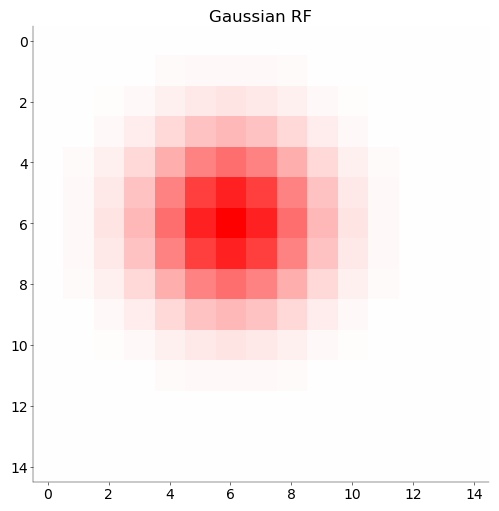

In [17]:
def gen_gauss_rf(D: int, width: float, center: tuple = (0, 0)) -> np.ndarray:
    """
    Generate a Gaussian receptive field.

    Args:
        D (int): Size of the receptive field (DxD).
        width (float): Width parameter of the Gaussian.
        center (tuple, optional): Center coordinates of the receptive field. Defaults to (0, 0).

    Returns:
        np.ndarray: Gaussian receptive field.
    """

    sz = (D - 1) / 2
    x, y = np.meshgrid(np.arange(-sz, sz + 1), np.arange(-sz, sz + 1))
    x = x + center[0]
    y = y + center[1]
    w = np.exp(-(x**2 / width + y**2 / width))
    w = w / np.sum(w.flatten())

    return w


w = gen_gauss_rf(15, 7, (1, 1))

vlim = np.max(np.abs(w))
fig, ax = plt.subplots(1, 1, figsize=(5, 5))
ax.imshow(w, cmap="bwr", vmin=-vlim, vmax=vlim)
ax.set_title("Gaussian RF")

In [18]:
def sample_lnp(
    w: np.array, nT: int, dt: float, R: float, s_i: float, random_seed: int = 10
):
    """Generate samples from an instantaneous LNP model neuron with
    receptive field kernel w.

    Parameters
    ----------

    w: np.array, (Dx * Dy, )
        (flattened) receptive field kernel.

    nT: int
        number of time steps

    dt: float
        duration of a frame in s

    R: float
        rate parameter

    s_i: float
        stimulus intensity peak to peak

    random_seed: int
        seed for random number generator

    Returns
    -------

    c: np.array, (nT, )
        sampled spike counts in time bins

    r: np.array, (nT, )
        mean rate in time bins

    s: np.array, (Dx * Dy, nT)
        stimulus frames used

    Note
    ----

    See equations in task description above for a precise definition
    of the individual parameters.

    """

    rng = np.random.default_rng(random_seed)

    # ------------------------------------------------
    # Generate samples from an instantaneous LNP model
    # neuron with receptive field kernel w. (1 pt)
    # ------------------------------------------------

    s = rng.choice([-s_i / 2, +s_i / 2], size=(w.size, nT))

    # linear projection: w^T s_t for each t
    lin = w.dot(s)  # shape (nT,)

    # instantaneous rate
    r = np.exp(lin) * dt * R  # shape (nT,)

    # Poisson spike counts
    c = rng.poisson(r)  # shape (nT,)

    return c, r, s

In [19]:
D = 15  # number of pixels
nT = 1000  # number of time bins
dt = 0.1  # bins of 100 ms
R = 50  # firing rate in Hz
s_i = 5  # stimulus intensity

w = gen_gauss_rf(D, 7, (1, 1))
w = w.flatten()

c, r, s = sample_lnp(w, nT, dt, R, s_i)

Plot the stimulus for one frame, the cell's response over time and the spike count vs firing rate.

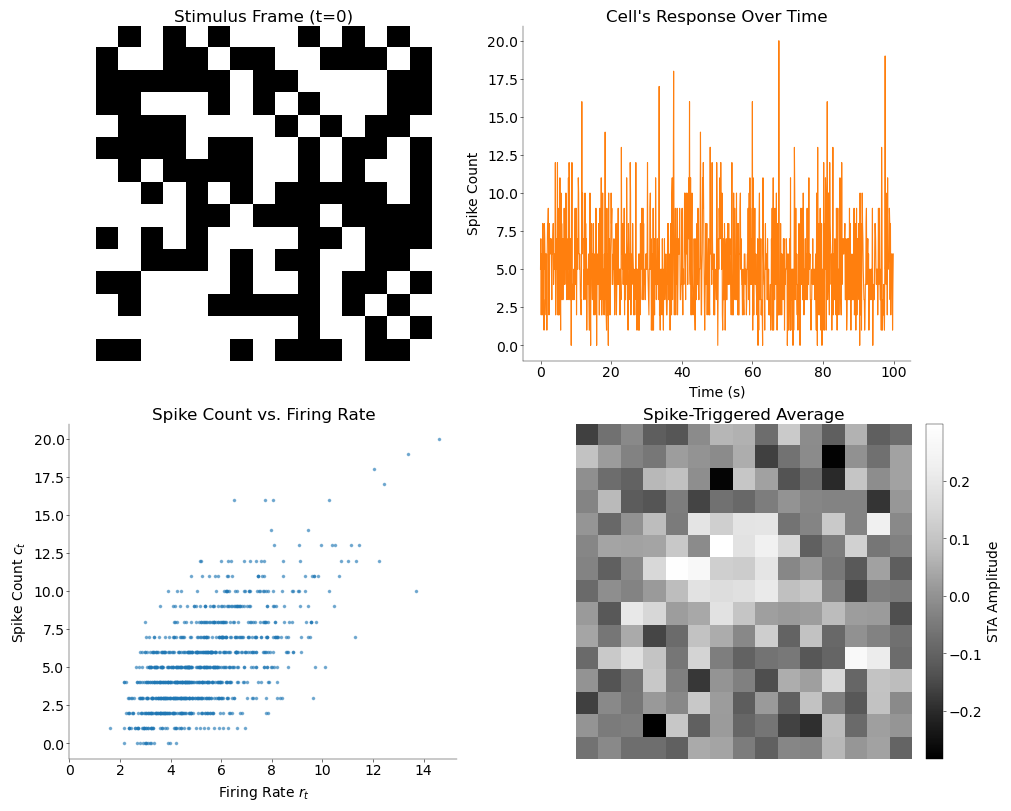

In [20]:
# mosaic = mosaic = [["stim", "responses", "count/rate"]]

# fig, ax = plt.subplot_mosaic(mosaic=mosaic, figsize=(15, 4))
# -----------------------------------------------------------------------------------------------------------
# Plot the stimulus for one frame, the cell's responses over time and spike count vs firing rate (1 pt)
# -----------------------------------------------------------------------------------------------------------

# compute STA (average stimulus preceding a spike)
# s: (D*D, nT), c: (nT,)
sta_flat = (s * c).sum(axis=1) / c.sum()  # weighted sum over time
sta = sta_flat.reshape(D, D)
sta = sta - np.mean(sta)  # zero-center

# Mosaic
mosaic = [["stim", "responses"], ["count/rate", "sta"]]


fig, ax = plt.subplot_mosaic(mosaic, figsize=(10, 8), constrained_layout=True)

# Panel 1
ax["stim"].imshow(
    s[:, 0].reshape(D, D),
    cmap="Greys_r",
    interpolation="nearest",
)
ax["stim"].set_title("Stimulus Frame (t=0)")
ax["stim"].axis("off")

# Panel 2
time = np.arange(nT) * dt
ax["responses"].plot(time, c, color="C1", linewidth=0.8)
ax["responses"].set_xlabel("Time (s)")
ax["responses"].set_ylabel("Spike Count")
ax["responses"].set_title("Cell's Response Over Time")

# Panel 3
ax["count/rate"].scatter(r, c, alpha=0.5, s=10)
ax["count/rate"].set_xlabel("Firing Rate $r_t$")
ax["count/rate"].set_ylabel("Spike Count $c_t$")
ax["count/rate"].set_title("Spike Count vs. Firing Rate")
ax["count/rate"].set_xlim(0, np.max(r) * 1.05)

# Panel 4 + colorbar
im = ax["sta"].imshow(
    sta,
    cmap="Greys_r",
    interpolation="nearest",
)
ax["sta"].set_title("Spike‐Triggered Average")
ax["sta"].axis("off")

# Constrained_layout-friendly colorbar
fig.colorbar(im, ax=ax["sta"], fraction=0.046, pad=0.04, label="STA Amplitude")

### Implementation (3 pts)

Implement the negative log-likelihood of the LNP and its gradient with respect to the receptive field using the simplified equations you calculated earlier _(1 pt)_

In [21]:
from scipy.special import gammaln


def negloglike_lnp(
    w: np.array, c: np.array, s: np.array, dt: float = 0.1, R: float = 50
) -> float:
    """Implements the negative (!) log-likelihood of the LNP model

    Parameters
    ----------

    w: np.array, (Dx * Dy, )
      current receptive field

    c: np.array, (nT, )
      spike counts

    s: np.array, (Dx * Dy, nT)
      stimulus matrix


    Returns
    -------

    f: float
      function value of the negative log likelihood at w

    """

    # ------------------------------------------------
    # Implement the negative log-likelihood of the LNP
    # ------------------------------------------------

    w = w.ravel()  # ensure shape (D,)
    lin = w @ s  # shape (nT,)
    rates = np.exp(lin) * dt * R  # shape (nT,)

    # term1: ∑ c_t · (w^T s_t)
    term1 = np.dot(c, lin)

    # term2: ∑ exp(w^T s_t) · (Δt·R)
    term2 = rates.sum()

    # term3: ∑ log(c_t!) = ∑ gammaln(c_t + 1)
    term3 = gammaln(c + 1).sum()

    # term4: ∑ c_t · log(Δt·R)
    log_dtR = np.log(dt * R)
    term4 = (c * log_dtR).sum()

    # full log-likelihood
    logL = term1 - term2 - term3 + term4

    # return *negative* log-likelihood
    return -logL


def deriv_negloglike_lnp(
    w: np.array, c: np.array, s: np.array, dt: float = 0.1, R: float = 50
) -> np.array:
    """
    Implements the gradient of the negative log-likelihood of the LNP model

    Parameters
    ----------

    see negloglike_lnp

    Returns
    -------

    df: np.array, (Dx * Dy, )
      gradient of the negative log likelihood with respect to w
    """
    w = w.ravel()  # ensure shape (D*D,)
    lin = w @ s  # shape (nT,)
    rates = np.exp(lin) * dt * R

    # gradient = ∑_t (r_t - c_t) s_t
    grad = s @ (rates - c)  # shape (D*D,)
    return grad

The helper function `check_grad` in `scipy.optimize` can help you to make sure your equations and implementations are correct. It might be helpful to validate the gradient before you run your optimizer.

In [22]:
# Check gradient
from scipy.optimize import check_grad


# A function Wrapper
def f_wrapper(w):
    return negloglike_lnp(w, c, s, dt=dt, R=R)


def grad_wrapper(w):
    return deriv_negloglike_lnp(w, c, s, dt=dt, R=R)


# Pick a random test point
w0_test = 0 * np.random.randn(D * D)
err = check_grad(f_wrapper, grad_wrapper, w0_test)


print(f"Gradient check error: {err:.3e}")

Gradient check error: 3.662e-03


Fit receptive field maximizing the log likelihood.

The scipy.optimize package also has suitable functions for optimization. If you generate a large number of samples, the fitted receptive field will look more similar to the true receptive field. With more samples, the optimization takes longer, however.

In [23]:
# ------------------------------------------
# Estimate the receptive field by maximizing
# the log-likelihood (or more commonly,
# minimizing the negative log-likelihood).
#
# Tips: use scipy.optimize.minimize(). (1 pt)
# ------------------------------------------

from scipy.optimize import minimize

# Set up initial guess
w0 = np.zeros(D * D)

# Minimize negative log‐likelihood
res = minimize(
    fun=lambda w: negloglike_lnp(w, c, s, dt=dt, R=R),
    x0=w0,
    jac=lambda w: deriv_negloglike_lnp(w, c, s, dt=dt, R=R),
    method="L-BFGS-B",
    options={"disp": False},  # silence the iteration log
)

w_est = res.x.reshape(D, D)  # reshape to original dimensions
# w_est = res.x / np.linalg.norm(res.x)
corr = np.corrcoef(w.flatten(), w_est.flatten())[0, 1]
print(f"Optimization complete. Pearson r = {corr:.3f}")

Optimization complete. Pearson r = 0.821


Plot the true and the estimated receptive field.

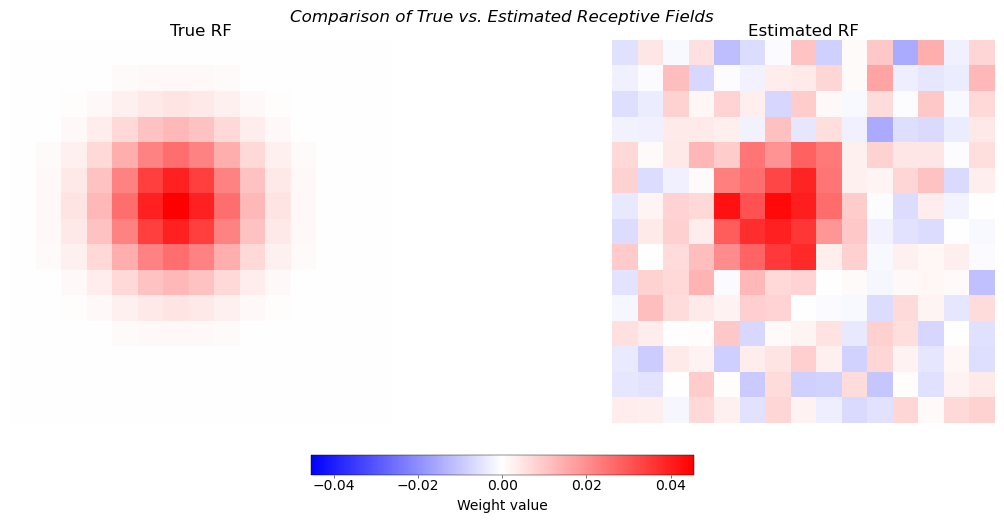

In [24]:
# ------------------------------------
# Plot the ground truth and estimated
# `w` side by side. (1 pt)
# ------------------------------------

# mosaic = [["True", "Estimated"]]
# fig, ax = plt.subplot_mosaic(mosaic=mosaic, figsize=(12, 5))

# make sure to add a colorbar. 'bwr' is a reasonable choice for the cmap.

mosaic = [["True", "Estimated"]]
fig, ax = plt.subplot_mosaic(mosaic=mosaic, figsize=(12, 5), constrained_layout=True)
fig.suptitle(
    "Comparison of True vs. Estimated Receptive Fields",
    fontsize=12,  # smaller than default
    fontstyle="italic",
    y=1.02,  # push it up a little
)

# make sure to add a colorbar. 'bwr' is a reasonable choice for the cmap.

# Shared color limits
vlim = max(np.abs(w).max(), np.abs(w_est).max())

# True RF
im0 = ax["True"].imshow(w.reshape(D, D), cmap="bwr", vmin=-vlim, vmax=vlim)
ax["True"].set_title("True RF")
ax["True"].axis("off")

# Estimated RF
im1 = ax["Estimated"].imshow(w_est.reshape(D, D), cmap="bwr", vmin=-vlim, vmax=vlim)
ax["Estimated"].set_title("Estimated RF")
ax["Estimated"].axis("off")

# Shared colorbar
fig.colorbar(
    im1,
    ax=[ax["True"], ax["Estimated"]],
    orientation="horizontal",
    fraction=0.05,
    pad=0.08,
    label="Weight value",
);

# Task 2: Apply to real neuron

Download the dataset for this task from Ilias (`nds_cl_5_data.mat`). It contains a stimulus matrix (`s`) in the same format you used before and the spike times. In addition, there is an array called `trigger` which contains the times at which the stimulus frames were swapped.

* Generate an array of spike counts at the same temporal resolution as the stimulus frames
* Fit the receptive field with time lags of 0 to 4 frames. Fit them one lag at a time (the ML fit is very sensitive to the number of parameters estimated and will not produce good results if you fit the full space-time receptive field for more than two time lags at once). 
* Plot the resulting filters

*Grading: 3.5 pts*


In [25]:
var = io.loadmat("../data/nds_cl_5_data.mat")

# t contains the spike times of the neuron
t = var["DN_spiketimes"].flatten()

# trigger contains the times at which the stimulus flipped
trigger = var["DN_triggertimes"].flatten()

# contains the stimulus movie with black and white pixels
s = var["DN_stim"]
s = s.reshape((300, 1500))  # the shape of each frame is (20, 15)
s = s[:, 1 : len(trigger)]

Create vector of spike counts

In [26]:
# ------------------------------------------
# Bin the spike counts at the same temporal
# resolution as the stimulus (0.5 pts)
# ------------------------------------------
spike_counts, _ = np.histogram(t, bins=trigger)
print("s.shape =", s.shape)
print("spike_counts.shape =", spike_counts.shape)
assert spike_counts.shape[0] == s.shape[1]

s.shape = (300, 1488)
spike_counts.shape = (1488,)


Fit receptive field for each frame separately

In [27]:
# ------------------------------------------
# Fit the receptive field with time lags of
# 0 to 4 frames separately (1 pt)
#
# The final receptive field (`w_hat`) should
# be in the shape of (Dx * Dy, 5)
# ------------------------------------------

# specify the time lags
delta = [0, 1, 2, 3, 4]

# fit for each
D1, D2 = 20, 15  # spatial dims
n_pixels = D1 * D2  # 300
n_lags = len(delta)  # 5
w_hat = np.zeros((n_pixels, n_lags))


# Define objective and gradient wrappers
def f_wrap(w, c_vec, S_mat):
    return negloglike_lnp(w, c_vec, S_mat, dt=1.0, R=1.0)


def g_wrap(w, c_vec, S_mat):
    return deriv_negloglike_lnp(w, c_vec, S_mat, dt=1.0, R=1.0)


# Loop over lags
for i, lag in enumerate(delta):
    # shift stimulus and counts
    if lag > 0:
        S_lag = s[:, :-lag]
        c_lag = spike_counts[lag:]
    else:
        S_lag = s.copy()
        c_lag = spike_counts.copy()

    # initial guess
    w0 = np.zeros(n_pixels)

    # fit via L-BFGS-B
    res = minimize(
        fun=lambda w: f_wrap(w, c_lag, S_lag),
        x0=w0,
        jac=lambda w: g_wrap(w, c_lag, S_lag),
        method="L-BFGS-B",
        options={"disp": False},
    )

    # normalize and store
    w_est = res.x
    # w_est /= np.linalg.norm(w_est)
    w_hat[:, i] = w_est

# Check shape
print("w_hat.shape:", w_hat.shape)  # should be (300, 5)

w_hat.shape: (300, 5)


Plot the frames one by one and explain what you see.

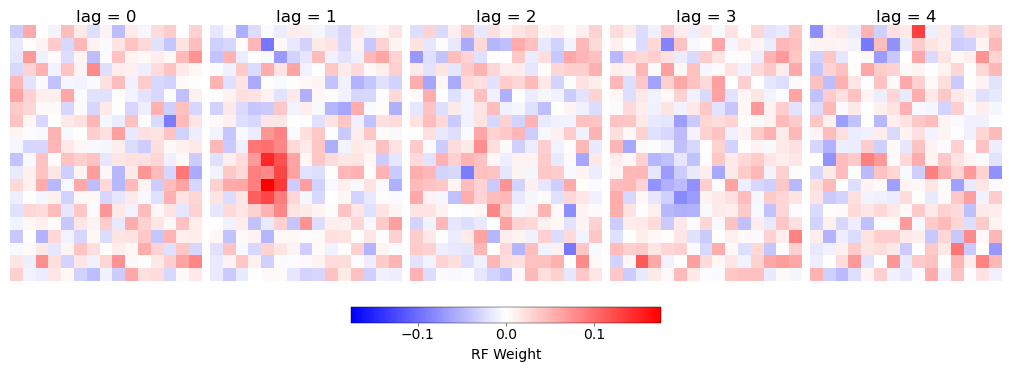

In [28]:
# --------------------------------------------
# Plot all 5 frames of the fitted RFs (1 pt)
# --------------------------------------------

fig, ax = plt.subplot_mosaic(mosaic=[delta], figsize=(10, 4), constrained_layout=True)

# Shared color-scale limit
vlim = np.max(np.abs(w_hat))


# Plot each lagged RF
for lag in delta:
    im = ax[lag].imshow(
        w_hat[:, lag].reshape(D1, D2), cmap="bwr", vmin=-vlim, vmax=vlim
    )
    ax[lag].set_title(f"lag = {lag}")
    ax[lag].axis("off")

# Add a single colorbar beneath all axes
fig.colorbar(
    im,
    ax=list(ax.values()),
    orientation="horizontal",
    fraction=0.05,
    pad=0.08,
    label="RF Weight",
);

_Explanation (1 pt)_

The five spatial maps illustrate the stimulus–response relationship of the neuron across delays of 0–4 frames. The receptive field exhibits a pronounced center-surround organization that attains maximal excitatory strength at lag 1, precisely coinciding with the Gaussian input profile, and subsequently attenuates. Notably, by lag 3, a polarity reversal emerges at the original stimulus location, reflecting a transient inhibitory rebound. These dynamics are indicative of a sharply tuned integration window, characterized by an early excitatory peak followed by brief suppression.

# Task 3: Separate space/time components

The receptive field of the neuron can be decomposed into a spatial and a temporal component. Because of the way we computed them, both are independent and the resulting spatio-temporal component is thus called separable. As discussed in the lecture, you can use singular-value decomposition to separate these two: 

$$
W = u_1 s_1 v_1^T
$$

Here $u_1$ and $v_1$ are the singular vectors belonging to the 1st singular value $s_1$ and provide a long rank approximation of W, the array with all receptive fields. It is important that the mean is subtracted before computing the SVD.  

Plot the first temporal component and the first spatial component. You can use a Python implementation of SVD. The results can look a bit puzzling, because the sign of the components is arbitrary.

*Grading: 1.5 pts*

In [29]:
# --------------------------------------------
# Apply SVD to the fitted receptive field,
# you can use either numpy or sklearn (0.5 pt)
# --------------------------------------------

# Center by subtracting each pixel’s mean over lags
W_centered = w_hat - w_hat.mean(axis=1, keepdims=True)

# Compute SVD
U, S, Vt = np.linalg.svd(W_centered, full_matrices=False)

# Extract first singular components
spatial1 = U[:, 0].reshape(D1, D2)  # first spatial singular vector
temporal1 = Vt[0, :]  # first temporal singular vector

# Print some diagnostics
print("First singular value s1 =", S[0])
print("spatial1.shape  =", spatial1.shape)
print("temporal1.shape =", temporal1.shape)

First singular value s1 = 0.587235009671892
spatial1.shape  = (20, 15)
temporal1.shape = (5,)


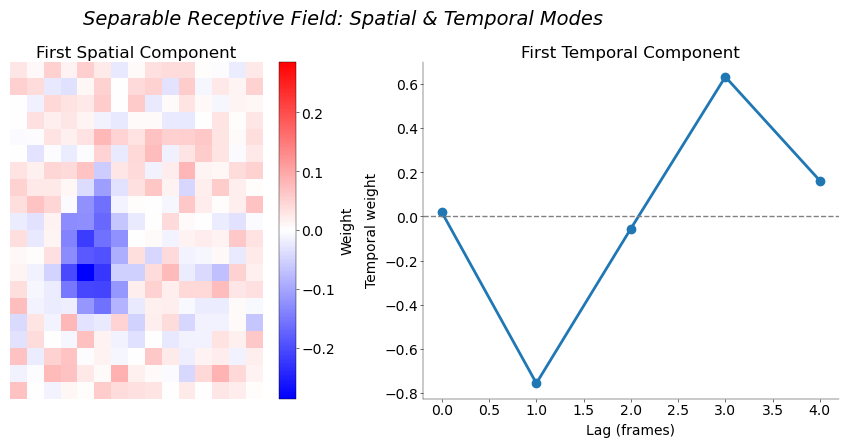

In [30]:
# -------------------------------------------------
# Plot the spatial and temporal components (1 pt)
# -------------------------------------------------

fig, ax = plt.subplot_mosaic(
    mosaic=[["Spatial", "Temporal"]], figsize=(10, 4), constrained_layout=True
)
# add plot

# --------------------------------------------
# Plot the spatial and temporal components
# --------------------------------------------

# Determine symmetric color limits for the spatial map
vlim = np.max(np.abs(spatial1))

# Panel 1: Spatial component
im = ax["Spatial"].imshow(
    spatial1, cmap="bwr", vmin=-vlim, vmax=vlim, interpolation="nearest"
)
ax["Spatial"].set_title("First Spatial Component")
ax["Spatial"].axis("off")
fig.colorbar(im, ax=ax["Spatial"], fraction=0.046, pad=0.04, label="Weight")

# — Panel 2: Temporal component —
lags = np.arange(temporal1.size)
ax["Temporal"].plot(lags, temporal1, marker="o", linestyle="-", linewidth=2)
ax["Temporal"].axhline(0, color="gray", linestyle="--", linewidth=1)
ax["Temporal"].set_xlabel("Lag (frames)")
ax["Temporal"].set_ylabel("Temporal weight")
ax["Temporal"].set_title("First Temporal Component")

# Super‐title and note
fig.suptitle(
    "Separable Receptive Field: Spatial & Temporal Modes",
    fontsize=14,
    fontstyle="italic",
    y=1.08,  # push it up so it doesn't overlap
);

# Task 4: Regularized receptive field

As you can see, maximum likelihood estimation of linear receptive fields can be quite noisy, if little data is available. 

To improve on this, one can regularize the receptive field vector and a term to the cost function


$$
C(w) = L(w) + \alpha ||w||_p^2
$$

Here, the $p$ indicates which norm of $w$ is used: for $p=2$, this is shrinks all coefficient equally to zero; for $p=1$, it favors sparse solutions, a penality also known as lasso. Because the 1-norm is not smooth at zero, it is not as straightforward to implement "by hand". 

Use a toolbox with an implementation of the lasso-penalization and fit the receptive field. Possibly, you will have to try different values of the regularization parameter $\alpha$. Plot your estimates from above and the lasso-estimates. How do they differ? What happens when you increase or decrease $alpha$?

If you want to keep the Poisson noise model, you can use the implementation in [`pyglmnet`](https://pypi.python.org/pypi/pyglmnet). Otherwise, you can also resort to the linear model from `sklearn` which assumes Gaussian noise (which in my hands was much faster).

*Grading: 3 pts*


## 1. Gaussian Noise Model

In [31]:
from sklearn.linear_model import Lasso
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline

# ------------------------------------------
# Fit the receptive field with time lags of
# 0 to 4 frames separately (the same as before)
# with sklearn or pyglmnet for different values
# of alpha (1 pt)
# ------------------------------------------

delta = [0, 1, 2, 3, 4]
D1, D2 = 20, 15
alphas = [0.01, 0.1, 1.0]  # you can tweak these

# Container: alpha → (D1*D2 × n_lags) array
w_lasso_dict = {}

for alpha in alphas:
    w_l = np.zeros((D1 * D2, len(delta)))
    for i, lag in enumerate(delta):
        # build X (n_samples × features) and y (n_samples,)
        if lag > 0:
            X = s[:, :-lag].T  # drop last lag columns
            y = spike_counts[lag:]  # drop first lag responses
        else:
            X = s.T
            y = spike_counts

        # pipeline: scale each pixel‐time‐series, then Lasso
        model = make_pipeline(
            StandardScaler(with_mean=False),
            Lasso(alpha=alpha, fit_intercept=False, max_iter=20000, tol=1e-4),
        )
        model.fit(X, y)
        coef = model.named_steps["lasso"].coef_

        # normalize to unit norm for visual comparison
        if np.linalg.norm(coef) > 0:
            coef = coef / np.linalg.norm(coef)

        w_l[:, i] = coef

    w_lasso_dict[alpha] = w_l

# confirm shapes
for alpha, W in w_lasso_dict.items():
    print(f"alpha={alpha:.3f}, shape={W.shape}")

alpha=0.010, shape=(300, 5)
alpha=0.100, shape=(300, 5)
alpha=1.000, shape=(300, 5)


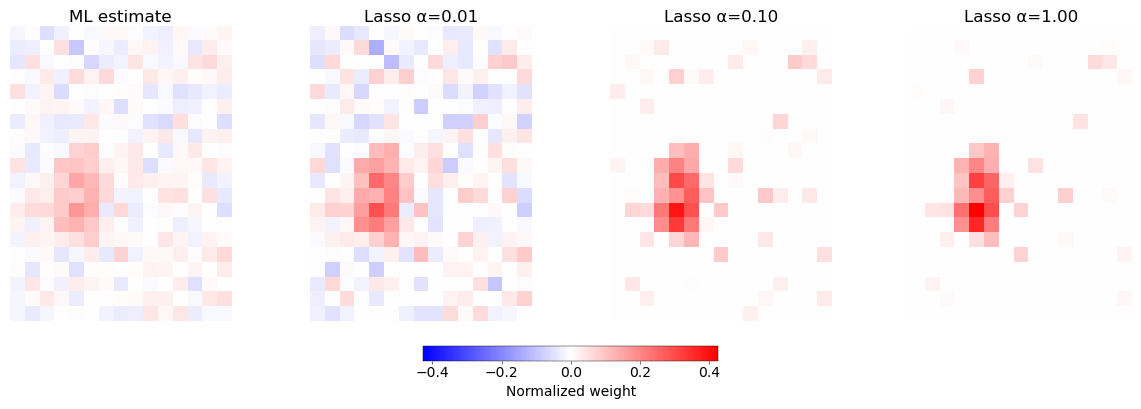

In [32]:
# ------------------------------------------
# plot the estimated receptive fields (1 pt)
# ------------------------------------------

lag = 1  # compare at the frame where the RF peaks
cols = ["ML"] + [f"α={a}" for a in alphas]

# 1×(1+len(alphas)) mosaic
fig, ax = plt.subplots(
    1, len(cols), figsize=(3 * len(cols), 4), constrained_layout=True
)

# shared color scale
maps = [w_hat[:, lag]] + [w_lasso_dict[a][:, lag] for a in alphas]
vlim = np.max(np.abs(maps))

for k, key in enumerate(cols):
    if key == "ML":
        img = w_hat[:, lag]
        title = "ML estimate"
    else:
        a = float(key.split("=")[1])
        img = w_lasso_dict[a][:, lag]
        title = f"Lasso α={a:.2f}"

    ax[k].imshow(
        img.reshape(D1, D2), cmap="bwr", vmin=-vlim, vmax=+vlim, interpolation="nearest"
    )
    ax[k].set_title(title)
    ax[k].axis("off")

# single colorbar
im = ax[-1].images[0]
fig.colorbar(
    im,
    ax=ax.tolist(),
    orientation="horizontal",
    fraction=0.05,
    pad=0.08,
    label="Normalized weight",
);

_Explanation (1 pt)_

The four panels compare the unregularized ML filter at lag 1 with Lasso‐regularized estimates at increasing α. The ML estimate (left) shows a noisy center–surround pattern. At α = 0.01, the core structure remains but peripheral noise is suppressed. By α = 0.10, only the strongest central pixels survive, yielding a sparser RF. At α = 1.00, nearly all weights collapse to zero, indicating over‐regularization. This progression illustrates how the ℓ₁ penalty trades off fidelity for sparsity in the fitted receptive field.

## 2. Poisson Noise Model

In [33]:
from pyglmnet import GLM


def fit_lasso_rf(
    full_stimulus_matrix: np.ndarray,  # Original s (num_pixels, num_total_frames)
    full_counts_vector: np.ndarray,  # Original c_binned (num_total_frames,)
    lag: int = 0,
    reg_strength: float = 0.1,  # This is the 'alpha' from your task's formula C(w)=L(w)+alpha*||w||_1
    max_iter: int = 1000,
    tol: float = 1e-4,
    learning_rate: float = 0.01,  # Added learning rate, may need tuning
) -> np.ndarray:
    """
    Fit a Lasso regularized receptive field using pyglmnet for a specific lag.

    Args:
        full_stimulus_matrix (np.ndarray): Stimulus matrix (Dx * Dy, nT).
        full_counts_vector (np.ndarray): Spike counts (nT,).
        lag (int): Time lag to apply.
        reg_strength (float): Regularization strength (lambda in pyglmnet).
        max_iter (int): Maximum number of iterations for optimization.
        tol (float): Tolerance for convergence.
        learning_rate (float): Learning rate for the optimizer.

    Returns:
        np.ndarray: Estimated receptive field (Dx * Dy,), or zeros if fit fails.
    """
    num_pixels = full_stimulus_matrix.shape[0]

    if lag == 0:
        stim_for_lag_samples = full_stimulus_matrix.T
        counts_for_lag = full_counts_vector
    else:
        if lag >= full_stimulus_matrix.shape[1] or lag >= len(full_counts_vector):
            print(f"Lag value {lag} is too large for data length. Returning zeros.")
            return np.zeros(num_pixels)
        # Stimulus at t-lag predicts spikes at t
        stim_for_lag_samples = full_stimulus_matrix[:, :-lag].T
        counts_for_lag = full_counts_vector[lag:]

    if stim_for_lag_samples.shape[0] == 0:
        print(f"Zero samples after lagging for lag {lag}. Returning zeros.")
        return np.zeros(num_pixels)
    if stim_for_lag_samples.shape[0] != len(counts_for_lag):
        print(
            f"Mismatch in samples after lagging for lag {lag}. "
            f"X has {stim_for_lag_samples.shape[0]}, y has {len(counts_for_lag)}. Returning zeros."
        )
        return np.zeros(num_pixels)

    model = GLM(
        distr="poisson",
        alpha=1.0,  # This is L1_ratio, 1.0 for pure Lasso
        reg_lambda=reg_strength,  # Regularization strength
        max_iter=max_iter,
        tol=tol,
        learning_rate=learning_rate,
        verbose=False,
    )

    try:
        # print( f"Fitting Lasso for lag {lag}, reg_strength {reg_strength} with X shape {stim_for_lag_samples.shape} and y shape {counts_for_lag.shape}")
        model.fit(stim_for_lag_samples, counts_for_lag)
        # NEW logic to access beta_:
        if model.beta_ is not None:
            # For pyglmnet.GLM with a single reg_lambda, beta_ is expected to be 1D (n_features,)
            if model.beta_.ndim == 1:
                # print(
                #     f"Fit successful for lag {lag}, reg_strength {reg_strength}. Beta shape: {model.beta_.shape}"
                # )
                return (
                    model.beta_.flatten()
                )  # .flatten() is mostly for consistency here
            elif model.beta_.ndim == 2 and model.beta_.shape[1] == 1:
                # print( f"Fit successful (beta_ is 2D) for lag {lag}, reg_strength {reg_strength}. Beta shape: {model.beta_.shape}")
                return model.beta_[:, 0].flatten()
            else:
                # This case would be unexpected
                # print(
                #     f"Unexpected beta_ shape from pyglmnet.GLM: {model.beta_.shape} for lag {lag}, reg_strength {reg_strength}"
                # )
                return np.zeros(num_pixels)
        else:
            # This case means fit might have run, but beta_ was not set (problematic)
            # print( f"Fit completed but model.beta_ is None for lag {lag}, reg_strength {reg_strength}.")
            return np.zeros(num_pixels)
    except Exception as e:
        print(
            f"Error during pyglmnet fit for lag {lag}, reg_strength {reg_strength}: {e}"
        )
        return np.zeros(num_pixels)

In [34]:
delta = [0, 1, 2, 3, 4]
alphas = np.logspace(-5, -3, 8)
np.float = np.float64
# Initialize for lasso results
w_hat_lasso_for_alpha = np.zeros((s.shape[0], len(delta), len(alphas)))
for alpha in alphas:
    for lag in delta:
        # Fit the Lasso regularized receptive field
        w_lasso = fit_lasso_rf(
            s,
            spike_counts,
            lag=lag,
            reg_strength=alpha,
            tol=5e-4,
            max_iter=4000,
            learning_rate=1e-4,
        )
        # Store the result in w_hat for plotting later
        w_hat_lasso_for_alpha[:, lag, np.where(alphas == alpha)[0][0]] = w_lasso

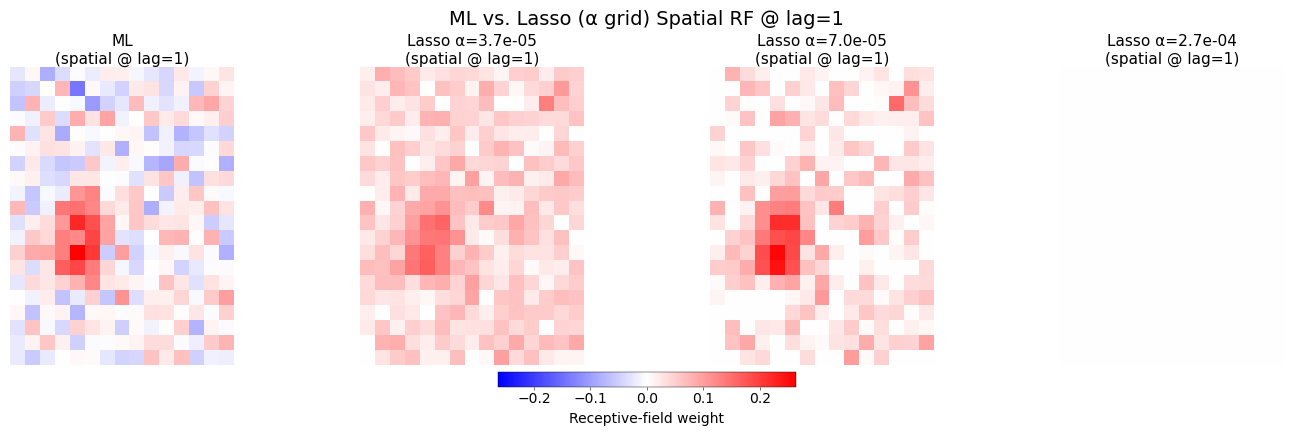

In [46]:
# ------------------------------------------
# plot the estimated receptive fields (1 pt)
# ------------------------------------------
from matplotlib.colors import TwoSlopeNorm

# pick the three points in your alpha grid plus ML
best_alpha = 7e-5
idx_mod = len(alphas) // 3
idx_best = np.argmin(np.abs(alphas - best_alpha))
idx_strong = 2 * len(alphas) // 3


denominator = np.linalg.norm(w_hat_lasso_for_alpha, axis=0, keepdims=True)

# Replace 0 in denominator with 1.0 to avoid 0/0 -> NaN; 0/1 -> 0.
safe_denominator = np.where(denominator == 0, 1.0, denominator)
normalized_w_hat_lasso = w_hat_lasso_for_alpha / safe_denominator

w_hat_normalized = w_hat / np.linalg.norm(w_hat, axis=0, keepdims=True)

methods = [
    ("ML", w_hat_normalized),
    (f"Lasso α={alphas[idx_mod]:.1e}", normalized_w_hat_lasso[:, :, idx_mod]),
    (f"Lasso α={best_alpha:.1e}", normalized_w_hat_lasso[:, :, idx_best]),
    (f"Lasso α={alphas[idx_strong]:.1e}", normalized_w_hat_lasso[:, :, idx_strong]),
]

# choose which lag to display (e.g. lag=1)
lag_to_plot = 1

# compute a shared, zero-centered colormap
vlim = max(np.abs(W[:, lag_to_plot]).max() for _, W in methods)
norm = TwoSlopeNorm(vmin=-vlim, vcenter=0.0, vmax=+vlim)

# make 1×4 figure
fig, axes = plt.subplots(1, 4, figsize=(14, 4), constrained_layout=True)

for col, (label, W) in enumerate(methods):
    ax = axes[col]
    im = ax.imshow(
        W[:, lag_to_plot].reshape(D1, D2),
        cmap="bwr",
        norm=norm,
        interpolation="nearest",
    )
    ax.set_title(label + f"\n(spatial @ lag={delta[lag_to_plot]})", fontsize=11)
    ax.axis("off")

# add a single horizontal colorbar
cbar = fig.colorbar(
    im,
    ax=axes.tolist(),
    orientation="horizontal",
    fraction=0.05,
    pad=0.02,
    label="Receptive-field weight",
)

fig.suptitle("ML vs. Lasso (α grid) Spatial RF @ lag=1", fontsize=14, y=1.05);

**Explanation (1 pt)**

The four panels compare the spatial receptive field at lag 1 under increasing L₁ regularization:

1. **ML (no penalty):** The classic center–surround profile is visible but overlaid with peripheral noise.  
2. **Lasso α≈3.7 × 10⁻⁵:** Background noise is substantially suppressed while the central excitatory focus remains.  
3. **Lasso α=7.0 × 10⁻⁵:** The surround is pruned further, isolating the core of the receptive field with minimal flank activity.  
4. **Lasso α≈2.7 × 10⁻⁴:** Over‐regularization drives almost all coefficients to zero, erasing both noise and true signal.

This progression illustrates the bias–variance trade-off: moderate L₁ sparsifies irrelevant pixels to boost signal-to-noise, but excessive penalty ultimately eliminates genuine receptive-field structure.  


## Bonus Task (Optional): Spike Triggered Average

Instead of the Maximum Likelihood implementation above, estimate the receptive field using the spike triggered average.
Use it to increase the temporal resolution of your receptive field estimate.
Perform the SVD analysis for your STA-based receptive field and plot the spatial and temporal kernel as in Task 3.

**Questions:**
1. Explain how / why you chose a specific time delta.
2. Reconsider what you know about STA. Is it suitable to use STA for this data? Why/why not? What are the (dis-)advantages of using the MLE based method from above?

_Grading: 1 BONUS Point._


_BONUS Points do not count for this individual coding lab, but sum up to 5% of your **overall coding lab grade**. There are 4 BONUS points across all coding labs._

In [36]:
# Center the stimulus (zero‐mean per pixel)
s_centered = s - s.mean(axis=1, keepdims=True)

# Frame duration (s)
dt_frame = np.mean(np.diff(trigger))

# How many lags (frames) you want in your STA
n_lags_sta = 20

# Build STA matrix: shape = (pixels, lags)
W_sta = np.zeros((D1 * D2, n_lags_sta))
total_spikes = spike_counts.sum()

for lag in range(n_lags_sta):
    # only consider times t ≥ lag+1
    t_idx = np.arange(lag + 1, spike_counts.size)
    # grab the stimulus lag frames before each spike
    stim_before = s_centered[:, t_idx - (lag + 1)]
    spks = spike_counts[t_idx]
    W_sta[:, lag] = (stim_before * spks).sum(axis=1) / total_spikes

times = (np.arange(n_lags_sta) + 1) * dt_frame  # array of shape (n_lags_sta,)
print(f"Frame Δt ≈ {dt_frame:.3f} s; STA spans {times[-1]:.2f} s back")

Frame Δt ≈ 0.215 s; STA spans 4.31 s back


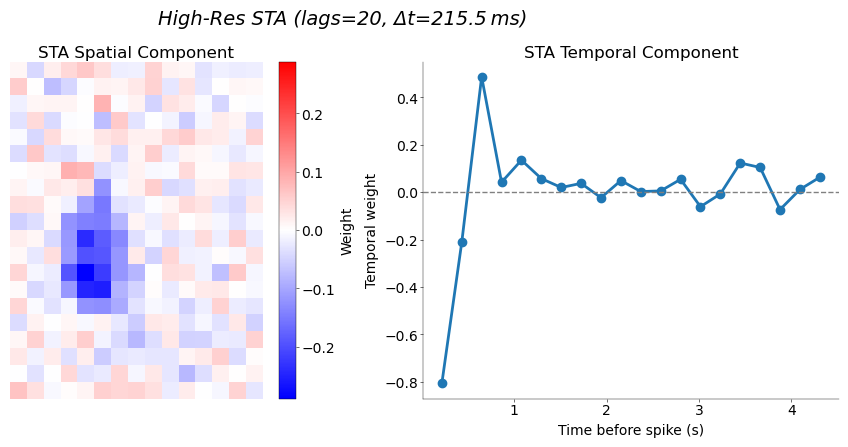

In [39]:
# Center across lags (zero‐mean per pixel)
Wc = W_sta - W_sta.mean(axis=1, keepdims=True)

# SVD
U, S, Vt = np.linalg.svd(Wc, full_matrices=False)
spatial1_sta = U[:, 0].reshape(D1, D2)
temporal1_sta = Vt[0, :]  # length = n_lags_sta

# Time‐axis in seconds before spike
times = (np.arange(n_lags_sta) + 1) * dt_frame

# Plot
fig, ax = plt.subplot_mosaic(
    [["Spatial", "Temporal"]], figsize=(10, 4), constrained_layout=True
)

# Spatial
vlim = np.max(np.abs(spatial1_sta))
im = ax["Spatial"].imshow(
    spatial1_sta, cmap="bwr", vmin=-vlim, vmax=vlim, interpolation="nearest"
)
ax["Spatial"].set_title("STA Spatial Component")
ax["Spatial"].axis("off")
fig.colorbar(im, ax=ax["Spatial"], fraction=0.046, pad=0.04, label="Weight")

# Temporal
ax["Temporal"].plot(times, temporal1_sta, marker="o", linewidth=2)
ax["Temporal"].axhline(0, color="gray", linestyle="--")
ax["Temporal"].set_xlabel("Time before spike (s)")
ax["Temporal"].set_ylabel("Temporal weight")
ax["Temporal"].set_title("STA Temporal Component")

fig.suptitle(
    f"High‐Res STA (lags={n_lags_sta}, Δt={dt_frame*1000:.1f} ms)",
    fontsize=14,
    fontstyle="italic",
    y=1.08,
);

### 1. Choice of Δt
I used the native frame interval (`dt_frame = mean(diff(trigger))`) with `n_lags_sta = 20`, so each STA lag corresponds to one frame (~215 ms), giving 20 evenly spaced samples over ~4.3 s.

### 2. STA vs. MLE
- **STA**  
  - **Pros:** trivial to code; reveals fine‐scale lag structure  
  - **Cons:** biased if stimuli are correlated; noisy with limited spikes  

- **MLE/GLM**  
  - **Pros:** can regularize (reducing bias & variance) & handles arbitrary spike statistics  
  - **Cons:** coarser temporal bins; more implementation complexity  
